#### 背景说明

每年高考高后都会有很多学生和家长为报专业而犯难，本次项目以全国各高校的信息以及专业开设信息进行分析，为考生志愿填报提供帮助。

#### 示例数据
项目数据为专业（professional）和学校（school）两份csv数据。</br>
* school：

| 字段      | 说明                                 |
| -------- | ---------------------------------------- |
| 学校    | 学校名称|
| 省份 | 省份，包含直辖市                             |
| 城市    | 地级市，不包含直辖市的区                                     |
| 地址  | 学校地址 |
| 水平层次  | 专科（高职）和普通本科 |
| 办学类别  | 学校类型，比如理工类，综合类，财经类，师范类，医药类等 |
| 办学类型  | 公办、民办或中外合资 |
| 985  | 是否为985院校 |
| 211  | 是否为211院校 |
| 双一流  | 是否为双一流院校 |
| 归属  | 隶属于哪个部门 |
| 开设专业链接  | 专业介绍的网页链接 |


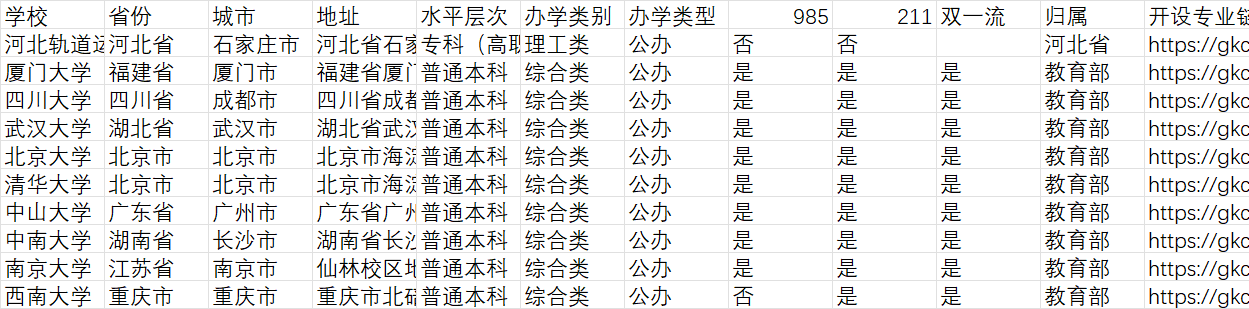

* professional

| 字段      | 说明                                 |
| -------- | ---------------------------------------- |
| 学校    | 学校名称|
| 专业类别 | 专业所属类别                             |
| 专业名称    | 专业的全称，包含定向类专业                                     |
| 国家特色专业  | 是否为国家特色专业 |
	
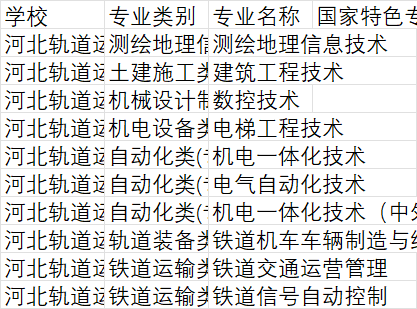

#### 分析思路
1.分析现有学校专业建设情况。由于专业名称中含有定向专业的名称需要去除，如：铁道交通运营管理（铁道旅客运输），另外还有一些无关字符也都要剔除。对清洗完的专业名称进行计数，可视化热度最高的专业。<br>
2.分析各省(市)高等教育水平实力分布。利用分组聚合的方式统计本科和专科学校的数量，然后用数据透视表功能做行列转换，并依此做堆积柱状图。<br>
3.分析湖北省双一流高校。展示出现频率较高的词汇。将professional和school两张表格按列拼接，筛选出湖北省内的双一流高校。然后对湖北双一流高校分别统计专业数量和特色专业数量，并绘制环形图进行对比分析。<br>
4.院校区域分析。利用分组聚合的方式统计各地级市的高校数量，利用pyecharts库进行地图可视化。<br>
5.分析北京市公办大学中专业名称包含“通信工程”的专业。基于共同列拼接professional和school两张表，按照“北京市”和“公办大学”筛选学校，最后在专业中筛选出含有“通信工程”的专业。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from pyecharts import options as opts
from pyecharts.charts import Map
import re

考点一：读取csv文件，设置编码方式

In [2]:
# 读取编码为gbk，名为professional的csv文件
df_pro = pd.read_csv('professional.csv',encoding='gbk')
df_pro.head()

,学校,专业类别,专业名称,国家特色专业
0,河北轨道运输职业技术学院,测绘地理信息类(专),测绘地理信息技术,NaN
1,河北轨道运输职业技术学院,土建施工类(专),建筑工程技术,NaN
2,河北轨道运输职业技术学院,机械设计制造类(专),数控技术,NaN
3,河北轨道运输职业技术学院,机电设备类(专),电梯工程技术,NaN
4,河北轨道运输职业技术学院,自动化类(专),机电一体化技术,NaN


考点一：读取csv文件，设置编码方式

In [3]:
# 读取编码为gbk，名为school的csv文件
df_sch = pd.read_csv('school.csv',encoding='gbk')
df_sch.head()

,学校,省份,城市,地址,水平层次,办学类别,办学类型,985,211,双一流,归属,开设专业链接
0,河北轨道运输职业技术学院,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional
1,厦门大学,福建省,厦门市,福建省厦门市思明区思明南路422号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/102/professional
2,四川大学,四川省,成都市,四川省成都市一环路南一段24号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/99/professional
3,武汉大学,湖北省,武汉市,湖北省武汉市武昌区八一路299号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/42/professional
4,北京大学,北京市,北京市,北京市海淀区颐和园路5号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/31/professional


## 1.分析现有学校专业建设情况
分析国内高校专业建设情况，统计热门专业TOP50。<br>
思路：由于专业名称中含有定向专业的名称需要去除，如：铁道交通运营管理（铁道旅客运输），另外还有一些无关字符也都要剔除。对清洗完的专业名称进行计数，可视化热度最高的专业。

1)专业名称中括号部分为补充说明，如培养方式等信息，需要将此部分内容清洗删除，如"机电一体化技术（中外合作办学）"清洗后为"机电一体化技术"；</br>
2)注意中英文括号混用、多用等情况，需要去除这些括号等特殊符号；

考点二：编译正则表达式替换函数，用于替换（剔除）括号中中英文等特殊符号

In [4]:
# 利用正则表达式去除括号及括号内的内容，并去除多余括号
# 正则替换函数
def sub(s):
    # 将字符替换为空
    x = re.sub(u"\（.*?\）|\(.*?\）|\（.*?\)|\(.*?\)|[()（）]", "", s) 
    return x 

考点三：调用正则替换函数，对专业名称进行清洗<br>

In [5]:
# 调用正则替换函数对“专业名称”进行清洗  
df_pro['专业名称_清洗'] = df_pro['专业名称'].apply(lambda x: sub(x))
df_pro.head()

,学校,专业类别,专业名称,国家特色专业,专业名称_清洗
0,河北轨道运输职业技术学院,测绘地理信息类(专),测绘地理信息技术,NaN,测绘地理信息技术
1,河北轨道运输职业技术学院,土建施工类(专),建筑工程技术,NaN,建筑工程技术
2,河北轨道运输职业技术学院,机械设计制造类(专),数控技术,NaN,数控技术
3,河北轨道运输职业技术学院,机电设备类(专),电梯工程技术,NaN,电梯工程技术
4,河北轨道运输职业技术学院,自动化类(专),机电一体化技术,NaN,机电一体化技术


考点四：对清洗后的专业名称进行计数统计，并将数据类型转换为dataframe

In [6]:
# 对“专业名称_清洗”列中不同专业的数量进行计数，并转化为dataframe
df1 = df_pro['专业名称_清洗'].value_counts().to_frame()
# 只选取前50个数据展示
df1 = df1.iloc[:50,:] # 取前50行数据
df1

# 示例数据
# 专业名称_清洗  计数
# 市场营销      1426

,专业名称_清洗
市场营销,1426
电子商务,1352
旅游管理,1204
物流管理,1146
财务管理,1019
会计,1013
计算机科学与技术,1000
英语,999
国际经济与贸易,878
工程造价,851


考点五：绘制横置条形图

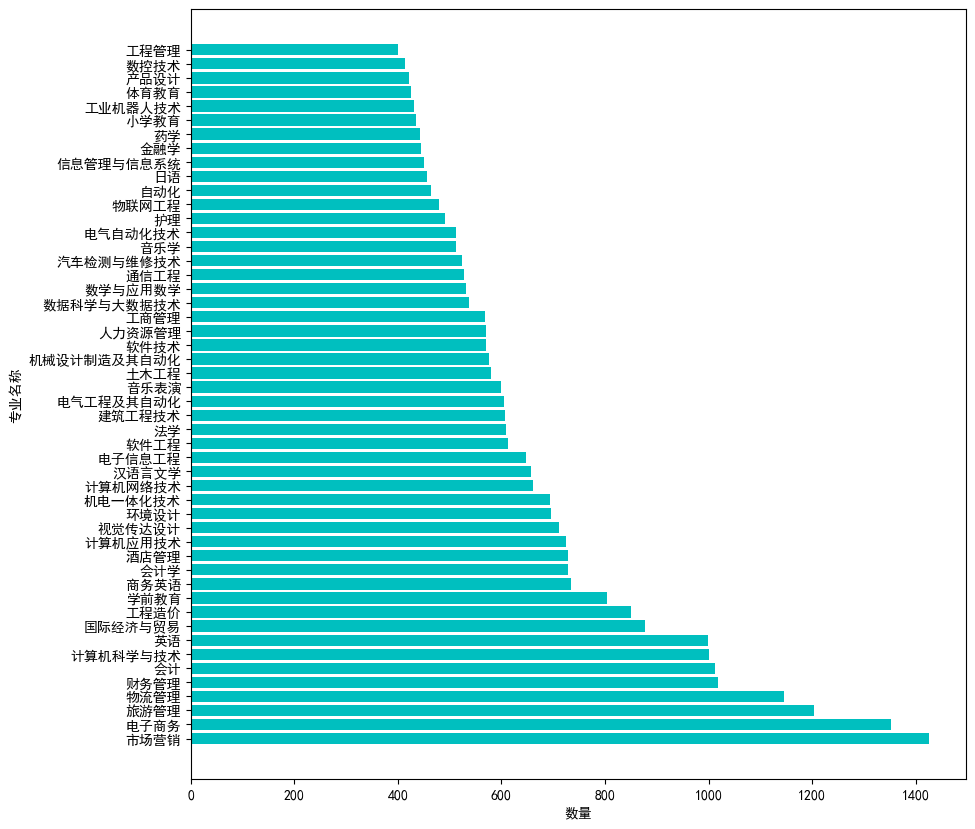

In [7]:
# 条形图展示各专业开设情况
# 设置图像大小（10,10）
plt.figure(figsize=(10,10))
# 横置条形图
plt.barh(df1.index,df1['专业名称_清洗'],color='c')
# 设置x轴标签
plt.xlabel('数量')
# 设置y轴标签
plt.ylabel('专业名称')
# 刻度标签
plt.xticks()
plt.show()

## 2.分析各省(市)高等教育水平实力分布
分析比较各省（市）本科和专科学校的数量以及学校总数，利用堆积柱状图进行可视化比较分析。

思路：利用分组聚合的方式统计本科和专科学校的数量，然后用数据透视表功能做行列转换，并依此做堆积柱状图。<br>


考点六：对省份和水平层次进行分组聚合，计算各省份不同层次办学数量。

In [8]:
# 按照“省份”和“水平层次”进行分组聚合，统计每个省市本科和专科学校的数量，重设索引，做数据透视表
df2 = df_sch.groupby([df_sch['省份'],df_sch['水平层次']])['学校'].count().reset_index().pivot(index='省份',columns="水平层次",values='学校')
df2

# 示例
# 水平层次	专科（高职）	普通本科
# 省份		
# 上海市	21.0	44.0

水平层次,专科（高职）,普通本科
省份,,
上海市,21.0,44.0
云南省,50.0,32.0
内蒙古自治区,37.0,19.0
北京市,25.0,77.0
吉林省,30.0,40.0
四川省,82.0,55.0
天津市,26.0,36.0
宁夏回族自治区,12.0,8.0
安徽省,76.0,52.0


考点七：调整为行索引为单层索引

In [9]:
# 调整行索引为单层索引，“水平层次”调整为列索引
df2.reset_index(inplace=True)
df2

水平层次,省份,专科（高职）,普通本科
0,上海市,21.0,44.0
1,云南省,50.0,32.0
2,内蒙古自治区,37.0,19.0
3,北京市,25.0,77.0
4,吉林省,30.0,40.0
5,四川省,82.0,55.0
6,天津市,26.0,36.0
7,宁夏回族自治区,12.0,8.0
8,安徽省,76.0,52.0
9,山东省,86.0,74.0


考点八：绘制堆叠柱状图，刻度标签倾斜60度

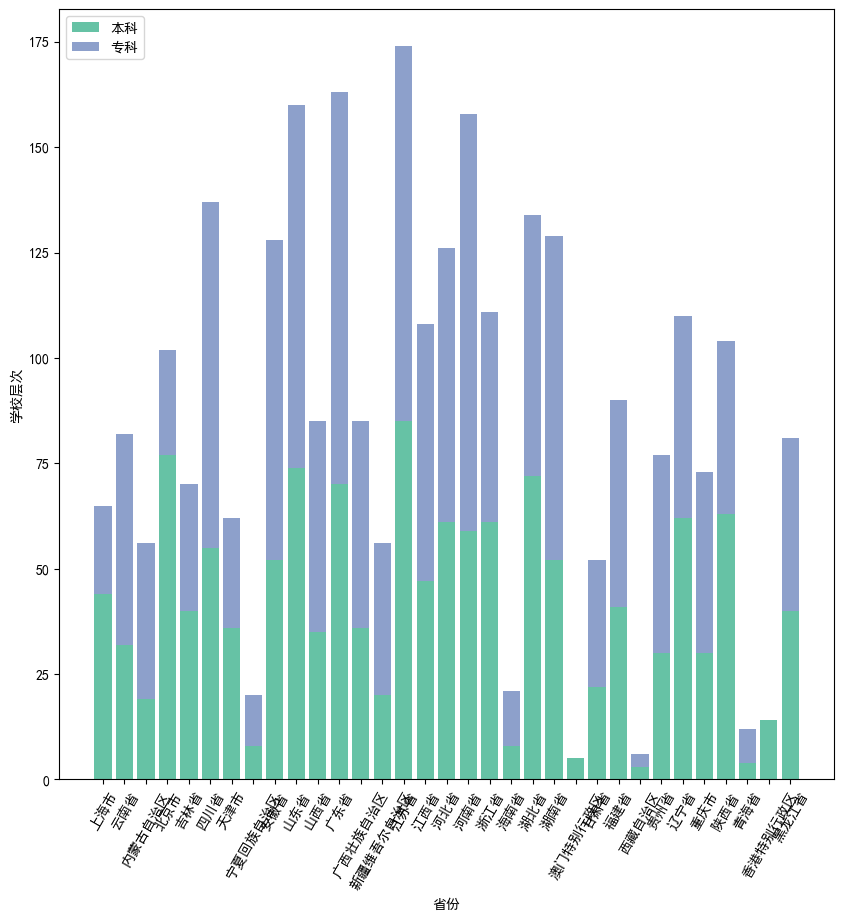

In [10]:
# 绘制各省份学校层次情况堆积柱状图

# 设置图像大小为（10,10）
plt.figure(figsize=(10,10))
# 柱状图。“普通本科”柱状图，设置横轴标签为“省份”
plt.bar(df2['省份'], df2['普通本科'], align='center', color='#66c2a5', tick_label=df2['省份'], label='本科')
# 柱状图。“专科（高职）”柱状图，堆积在“普通本科”柱状图上
plt.bar(df2['省份'], df2['专科（高职）'],  bottom=df2['普通本科'], color='#8da0cb', label='专科')  
# 设置x轴标签
plt.xlabel('省份')
# 设置y轴标签
plt.ylabel('学校层次')
# 刻度标签倾斜60度
plt.xticks(rotation=60)
# 显示图例
plt.legend()  
plt.show()

## 3.分析湖北省双一流高校
分析湖北的双一流高校，对各学校的专业和特色专业进行对比分析。<br>
思路：将professional和school两张表格按列拼接，筛选出湖北省内的双一流高校。然后对湖北双一流高校分别统计专业数量和特色专业数量，并绘制环形图进行对比分析。

考点九：基于相同列进行数据合并

In [11]:
# 基于相同列拼接df_pro和df_sch
df3 = pd.merge(df_pro,df_sch)
df3.head()

,学校,专业类别,专业名称,国家特色专业,专业名称_清洗,省份,城市,地址,水平层次,办学类别,办学类型,985,211,双一流,归属,开设专业链接
0,河北轨道运输职业技术学院,测绘地理信息类(专),测绘地理信息技术,NaN,测绘地理信息技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional
1,河北轨道运输职业技术学院,土建施工类(专),建筑工程技术,NaN,建筑工程技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional
2,河北轨道运输职业技术学院,机械设计制造类(专),数控技术,NaN,数控技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional
3,河北轨道运输职业技术学院,机电设备类(专),电梯工程技术,NaN,电梯工程技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional
4,河北轨道运输职业技术学院,自动化类(专),机电一体化技术,NaN,机电一体化技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional


考点十：按要求筛选出湖北省双一流建设名单并输出学校名称

In [12]:
# 筛选出“湖北省”的“双一流”的大学
df_hubei= df3[(df3['省份']=='湖北省')&(df3['双一流']=='是')]
df_hubei.head()

,学校,专业类别,专业名称,国家特色专业,专业名称_清洗,省份,城市,地址,水平层次,办学类别,办学类型,985,211,双一流,归属,开设专业链接
251,武汉大学,哲学类(本),哲学,是,哲学,湖北省,武汉市,湖北省武汉市武昌区八一路299号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/42/professional
252,武汉大学,哲学类(本),宗教学,NaN,宗教学,湖北省,武汉市,湖北省武汉市武昌区八一路299号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/42/professional
253,武汉大学,经济学类(本),经济学,是,经济学,湖北省,武汉市,湖北省武汉市武昌区八一路299号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/42/professional
254,武汉大学,财政学类(本),财政学,NaN,财政学,湖北省,武汉市,湖北省武汉市武昌区八一路299号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/42/professional
255,武汉大学,金融学类(本),金融学,NaN,金融学,湖北省,武汉市,湖北省武汉市武昌区八一路299号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/42/professional


In [13]:
df_hubei['学校'].unique() 

array(['武汉大学', '华中科技大学', '武汉理工大学', '中南财经政法大学', '华中师范大学', '中国地质大学（武汉）',
       '华中农业大学'], dtype=object)

## 4.院校区域分析
按照“地级市”进行的高校分布解读，统计各省份学校数量，使用中国地图进行可视化展示。<br>
思路：利用分组聚合的方式统计各地级市的高校数量，利用pyecharts库进行地图可视化。

考点十一：借助地图对院校进行区域数据可视化

In [14]:
# 按“城市”进行分组聚合，统计“学校”的数量
df4 = df_sch.groupby([df_sch['城市']])['学校'].count()
# “学校”数量降序排列
df4.sort_values(ascending=False)

城市
北京市       102
武汉市        87
广州市        85
重庆市        73
郑州市        70
         ... 
定西市         1
锡林郭勒盟       1
大兴安岭地区      1
塔城地区        1
七台河市        1
Name: 学校, Length: 329, dtype: int64

考点十二：使用notebook网页形式进行渲染生成图形

In [15]:
# 取Series的索引和值，转换为list
attr = df4.index.tolist() # 索引
value = df4.values.tolist() # 值

c = (
    # 地理区域数据的可视化
    Map()
        # 设置图标题，省及对应数量，中国地级市地图，不显示标签
        .add(
            "各市学校分布", 
            [list(z) for z in zip(attr, value)], 
            "china-cities",
            label_opts=opts.LabelOpts(is_show=False),
            )
        # 全局配置，配置全局标题，视觉映射配置项
        .set_global_opts(
                        title_opts=opts.TitleOpts(title="各市学校分布"), 
                        visualmap_opts=opts.VisualMapOpts()
    )
      
)
# 渲染图片并显示
c.render_notebook()

## 5.分析北京市公办大学中专业名称包含“通信工程”的专业
现有学生，想报考北京公办大学中的"通信工程"专业。请根据要求进行分析，筛选出学生想要报考大学及专业的全部信息。<br>
思路：基于共同列拼接professional和school两张表，按照“北京市”和“公办大学”筛选学校，最后在专业中筛选出含有“通信工程”的专业。

In [16]:
# 基于相同列拼接df_pro和df_sch
df5 = pd.merge(df_pro,df_sch)
df5.head()

,学校,专业类别,专业名称,国家特色专业,专业名称_清洗,省份,城市,地址,水平层次,办学类别,办学类型,985,211,双一流,归属,开设专业链接
0,河北轨道运输职业技术学院,测绘地理信息类(专),测绘地理信息技术,NaN,测绘地理信息技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional
1,河北轨道运输职业技术学院,土建施工类(专),建筑工程技术,NaN,建筑工程技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional
2,河北轨道运输职业技术学院,机械设计制造类(专),数控技术,NaN,数控技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional
3,河北轨道运输职业技术学院,机电设备类(专),电梯工程技术,NaN,电梯工程技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional
4,河北轨道运输职业技术学院,自动化类(专),机电一体化技术,NaN,机电一体化技术,河北省,石家庄市,"河北省石家庄市经济技术开发区赣江路9号,石家庄市宁安路189号",专科（高职）,理工类,公办,否,否,NaN,河北省,https://gkcx.eol.cn/school/2858/professional


In [17]:
# 筛选“城市”为“北京”且“办学类型”是“公办”的大学
df_bj = df5[(df5['城市']=='北京市')&(df5['办学类型']=='公办')]
df_bj.head()

,学校,专业类别,专业名称,国家特色专业,专业名称_清洗,省份,城市,地址,水平层次,办学类别,办学类型,985,211,双一流,归属,开设专业链接
377,北京大学,哲学类(本),哲学,是,哲学,北京市,北京市,北京市海淀区颐和园路5号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/31/professional
378,北京大学,哲学类(本),宗教学,NaN,宗教学,北京市,北京市,北京市海淀区颐和园路5号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/31/professional
379,北京大学,哲学类(本),逻辑学,NaN,逻辑学,北京市,北京市,北京市海淀区颐和园路5号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/31/professional
380,北京大学,经济学类(本),经济学,是,经济学,北京市,北京市,北京市海淀区颐和园路5号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/31/professional
381,北京大学,经济学类(本),资源与环境经济学,NaN,资源与环境经济学,北京市,北京市,北京市海淀区颐和园路5号,普通本科,综合类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/31/professional


考点十三：检查数据是否包含某一字符串

In [18]:
# 在上一步基础上，将“专业名称_清洗”列转换为字符串，判断是否包含和“通信工程”
df_bj[df_bj['专业名称_清洗'].str.contains('通信工程')]

,学校,专业类别,专业名称,国家特色专业,专业名称_清洗,省份,城市,地址,水平层次,办学类别,办学类型,985,211,双一流,归属,开设专业链接
1524,北京邮电大学,电子信息类(本),通信工程,是,通信工程,北京市,北京市,北京市西土城路10号,普通本科,理工类,公办,否,是,是,教育部,https://gkcx.eol.cn/school/48/professional
5752,北京航空航天大学,电子信息类(本),通信工程,是,通信工程,北京市,北京市,学院路校区：北京市海淀区学院路37号;沙河校区：北京市昌平区沙河高教园区,普通本科,理工类,公办,是,是,是,工业和信息化部,https://gkcx.eol.cn/school/47/professional
7144,中国传媒大学,电子信息类(本),通信工程,NaN,通信工程,北京市,北京市,北京市朝阳区定福庄东街一号,普通本科,艺术类,公办,否,是,是,教育部,https://gkcx.eol.cn/school/558/professional
7147,中国传媒大学,电子信息类(本),通信工程（无线多媒体广播技术方向）,NaN,通信工程,北京市,北京市,北京市朝阳区定福庄东街一号,普通本科,艺术类,公办,否,是,是,教育部,https://gkcx.eol.cn/school/558/professional
7847,北京工业大学,电子信息类(本),通信工程,NaN,通信工程,北京市,北京市,"平乐园校区：北京市朝阳区平乐园100号,通州校区：北京市通州区潞苑南大街89号",普通本科,理工类,公办,否,是,是,北京市,https://gkcx.eol.cn/school/30/professional
8971,北京交通大学,电子信息类(本),通信工程,是,通信工程,北京市,北京市,北京市海淀区西直门外上园村3号,普通本科,理工类,公办,否,是,是,教育部,https://gkcx.eol.cn/school/38/professional
9365,华北电力大学,电子信息类(本),通信工程,NaN,通信工程,北京市,北京市,北京市昌平区回龙观北农路2号,普通本科,理工类,公办,否,是,是,教育部,https://gkcx.eol.cn/school/831/professional
10828,中国农业大学,电子信息类(本),通信工程,NaN,通信工程,北京市,北京市,北京市海淀区清华东路17号,普通本科,农林类,公办,是,是,是,教育部,https://gkcx.eol.cn/school/557/professional
10894,北京科技大学,电子信息类(本),通信工程,NaN,通信工程,北京市,北京市,北京市海淀区学院路30号,普通本科,理工类,公办,否,是,是,教育部,https://gkcx.eol.cn/school/144/professional
13272,北京联合大学,电子信息类(本),通信工程,是,通信工程,北京市,北京市,北京市朝阳区北四环东路97号,普通本科,综合类,公办,否,否,NaN,北京市,https://gkcx.eol.cn/school/575/professional
